In [55]:
# The magic commands below allow reflecting the changes in an imported module without restarting the kernel.
%load_ext autoreload
%autoreload 2

# We need to add balsam and the modules it depends on to the Python search paths. 
import sys
sys.path.insert(0,'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/')
sys.path.insert(0,'/soft/datascience/Balsam/0.3.5.1/')

import matplotlib.pyplot
#sys.path.insert(0,'/lus/theta-fs0/projects/connectomics_aesp/software/neuro_env_36/lib/python3.6/site-packages/')


from pprint import pprint
pprint(f'Python search path includes: {sys.path}')

# We also need postgresql to be in the path
import os
os.environ['PATH'] ='/soft/datascience/Balsam/0.3.5.1/env/bin/:' + os.environ['PATH']
os.environ['PATH'] +=':/soft/datascience/PostgreSQL/9.6.12/bin/'

try:
    import balsam
except:
    print('Cannot find balsam, make sure balsam is installed or it is available in Python search paths')    

    # We also need to activate Balsam database by setting the BALSAM_DB_PATH environment variable. 
# This is equivalent to `source balsamactivate jupyter_test` 
os.environ["BALSAM_DB_PATH"]='/lus/theta-fs0/projects/connectomics_aesp/balsam_database/'


from balsam_helper import *
import hpn_balsam_apps

print(os.environ["BALSAM_DB_PATH"])

Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
("Python search path includes: ['/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/soft/

# TRAKEM2 PREAMBLE AND JOBS

In [13]:

##Fix import from HPN
from HappyNeurons import trakem2

ModuleNotFoundError: No module named 'HappyNeurons'

In [ ]:


RAW_INPUT=./trakem2_HL00732
PROCESS_FOLDER=./trakem2_HL00732_process_3
MIN=1024
MAX=2048

##add pre align tiles files
#python $PRE_TILES $RAW_INPUT $PROCESS_FOLDER/align_raw.txt 

def sem_montage_job(workflow_name, folder):
    montage_args = ''
    montage_args += f' $PROCESS_FOLDER/align_raw.txt '
    montage_args += f' $PROCESS_FOLDER '
    montage_args += f' --min $MIN '
    montage_args += f' --max $MAX '
    montage_args += f' --fiji $FIJI '
    print(montage_args)

    add_job(name=f'montage',
        workflow=workflow_name,
        data={folder}
        application='trakem2_montage',
        args=montage_args,
        ranks_per_node=1,
        environ_vars='OMP_NUM_THREADS=32')





# python $PRE_STACK $PROCESS_FOLDER/output $PROCESS_FOLDER/align_new.txt #input #output

#SERIAL SINGLE NODE OPERATION!!!
# $SUBMIT_THETA python $ALIGN $PROCESS_FOLDER/align_new.txt $PROCESS_FOLDER/align1 --fiji $FIJI

#$SUBMIT_THETA python $EXPORT $PROCESS_FOLDER/align_new.txt $PROCESS_FOLDER/align1 --range $RANGE --fiji $FIJI
#sleep 1

    

# FLOOD FILL NETWORK PREAMBLE AND JOBS

In [16]:
import sys
sys.path.insert(0,'/gpfs/mira-home/keceli/ffn/keceli_ffn/')
sys.path.insert(0,'/lus/theta-fs0/projects/connectomics_aesp/keceli/pip_ffn/')
sys.path.insert(0,'/soft/datascience/tensorflow/tf1.13/')

from ffn.utils import bounding_box
from ffn.utils import geom_utils

def create_inference_config(pars, file_name):
    request_par = ('''image {
                  hdf5: "%s:%s"
                }
                image_mean: %s
                image_stddev: %s
                checkpoint_interval: 1800
                seed_policy: "PolicyPeaks"
                model_checkpoint_path: "%s"
                model_name: "convstack_3d.ConvStack3DFFNModel"
                model_args: "{\\"depth\\": 2, \\"fov_size\\": [5,5,5], \\"deltas\\": [1, 1, 1]}"
                segmentation_output_dir: "%s"
                inference_options {
                  init_activation: 0.9
                  pad_value: 0.05
                  move_threshold: 0.1
                  min_boundary_dist { x: 1 y: 1 z: 1}
                  segment_threshold: 0.08
                  min_segment_size: 10
                }''') % pars
    print (request_par)

def divide_bounding_box(bbox, subvolume_size, overlap):
    """
    Returns a list of bounding boxes that divides the given bounding box into subvolumes.
    Parameters
    ----------
    bbox: BoundingBox object,
    subvolume_size: list or tuple
    overlap: list or tuple
    """
    start = geom_utils.ToNumpy3Vector(bbox.start)
    size = geom_utils.ToNumpy3Vector(bbox.size)
    bbox = bounding_box.BoundingBox(start, size)
    calc = bounding_box.OrderlyOverlappingCalculator(outer_box=bbox, 
                                                    sub_box_size=subvolume_size, 
                                                    overlap=overlap, 
                                                    include_small_sub_boxes=True,
                                                    back_shift_small_sub_boxes=False)
    return [bb for bb in calc.generate_sub_boxes()]

def check_balsam_jobs(bbox, config_file):
    for i,box in enumerate(boxes):
        start = box.start
        size  = box.size
        print(f" --bounding_box 'start {{ x:{start[0]} y:{start[1]} z:{start[2]} }} size {{ x:{size[0]} y:{size[1]} z:{size[2]} }}' ")
    print(f" --inference_request=\"$(cat "+config_file+")\" ")


def generate_balsam_inference_jobs(bbox_list, config_file, workflow_name='ffn_sub_inference'):
    for i,box in enumerate(bbox_list):
        start = box.start
        size  = box.size
        inference_args  = f" --inference_request=\"$(cat "+config_file+")\" "
        inference_args += f" --bounding_box 'start {{ x:{start[0]} y:{start[1]} z:{start[2]} }} size {{ x:{size[0]} y:{size[1]} z:{size[2]} }}' "
        add_job(name=f'sub_inference_{i}',
                workflow=workflow_name,
                application='inference',
                args=inference_args,
                ranks_per_node=1,
                environ_vars='OMP_NUM_THREADS=32')

# Flood Fill Network Training Job

In [40]:
import time
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'
TIMESTAMP=time.strftime("%y%m%d%H%M%S")
TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_{TIMESTAMP}'


##make all of bellow into a single function that receives all of the above!!

myargs = ''
myargs += f' --train_coords {TFRECORDFILE} '
myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
myargs += ' --image_mean 128 --image_stddev 33 '
myargs += ' --max_steps 400 --summary_rate_secs 60 ' 
myargs += f' --batch_size {BATCHSIZE} '
myargs += f' --optimizer {OPTIMIZER} '
myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
myargs += f' --train_dir {TRAINDIR} '
print(myargs)

add_job(name='test_train',workflow='ffn_training',application='trainer',args=myargs)

 --train_coords /lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file  --data_volumes valdation1:/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5:raw  --label_volumes valdation1:/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5:stack  --model_name convstack_3d.ConvStack3DFFNModel  --model_args "{\"depth\": 12, \"fov_size\": [33, 33, 33], \"deltas\": [8, 8, 8]}" --image_mean 128 --image_stddev 33  --max_steps 400 --summary_rate_secs 60  --batch_size 1  --optimizer adam  --num_intra_threads 64 --num_inter_threads 1  --train_dir train_b1_oadam_191001210138 


# Flood Fill Network Inference Job

In [21]:
# Add inference jobs for each subvolume


INPUT_FILE = 'input_file_parallel.h5'
INPUT_DSET = 'image'
OUTPUT_FILE = 'output_file_parallel.h5'
OUTPUT_DSET = 'image'
OUTPUT_PATH = 'results_test_parallel6'
MEAN = 100
STD = 30
MODEL_PATH = 'model_vessel/model.ckpt-1680104'
DEPTH = 2
START = (0,0,0)
SIZE = (1000,1000,1000)
CHUNK_SIZE = (256,256,256)
OVERLAP = (16,16,16)


##cleanup all of the bellow to receive in a single function all of the above.

bbox = bounding_box.BoundingBox(start=START,size=SIZE)
pars =  (INPUT_FILE,INPUT_DSET, MEAN, STD, MODEL_PATH, OUTPUT_PATH)

test = create_inference_config(pars, 'test')
config_file = '/lus/theta-fs0/projects/connectomics_aesp/ravescovi/ffn_vessels_overlay_sean_anno/wholebrain.pbtxt'

boxes = divide_bounding_box(bbox,subvolume_size=CHUNK_SIZE,overlap=OVERLAP)
print(f'Number of subvolumes: {len(boxes)}')

generate_balsam_inference_jobs(boxes, config_file, workflow_name='inference_8_8_v12')


image {
                  hdf5: "input_file_parallel.h5:image"
                }
                image_mean: 100
                image_stddev: 30
                checkpoint_interval: 1800
                seed_policy: "PolicyPeaks"
                model_checkpoint_path: "model_vessel/model.ckpt-1680104"
                model_name: "convstack_3d.ConvStack3DFFNModel"
                model_args: "{\"depth\": 2, \"fov_size\": [5,5,5], \"deltas\": [1, 1, 1]}"
                segmentation_output_dir: "results_test_parallel6"
                inference_options {
                  init_activation: 0.9
                  pad_value: 0.05
                  move_threshold: 0.1
                  min_boundary_dist { x: 1 y: 1 z: 1}
                  segment_threshold: 0.08
                  min_segment_size: 10
                }
Number of subvolumes: 125
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


# BALSAM WORKFLOW SUBMISSION

In [22]:
# If you see 'Submit OK:', Job submission is succesful.

workflow = 'inference_8_8_v12'

submit(project='SDL_workshop',
       queue='training',
       nodes=128,
       wall_minutes=40,
       wf_filter=workflow)


Submit OK: Qlaunch {   'command': '/lus/theta-fs0/projects/connectomics_aesp/balsam_database/qsubmit/qlaunch66.sh',
    'from_balsam': True,
    'id': 66,
    'job_mode': 'mpi',
    'nodes': 128,
    'prescheduled_only': False,
    'project': 'SDL_workshop',
    'queue': 'training',
    'scheduler_id': 375826,
    'state': 'submitted',
    'wall_minutes': 40,
    'wf_filter': 'inference_8_8_v12'}


# BALSAM WORKFLOW ANALISER

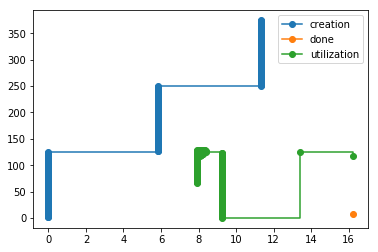

In [42]:
# Balsam metadata
from balsam.core.models import utilization_report, throughput_report, process_job_times, BalsamJob
from matplotlib import pyplot as plt

workflow = "inference_8_8_v12"

##useful shit
query = BalsamJob.objects.filter(workflow=workflow)
time_dat = process_job_times(query) #filters into a single workflow
[j.runtime_seconds for j in query] # full time per balsam Job

times_created, num_created = sorted(time_dat['CREATED']), range(1, len(time_dat["CREATED"])+1)

t0 = min(times_created)

def mins(t):
    return (t-t0).total_seconds() / 60

plt.step([mins(t) for t in times_created] ,num_created, 'o', where='post',label='creation')
times, num_thru = throughput_report(time_dat)
plt.step([mins(t) for t in times], num_thru,  'o', where='post', label='done')

times_u, num_util = utilization_report(time_dat)
plt.step([mins(t) for t in times_u], num_util, 'o', where='post', label='utilization')
plt.legend()

In [28]:
import matplotlib.pyplot

ImportError: cannot import name '_path'

# Flood Fill Network MultScale Training Job

In [ ]:
#multiscale training job
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'

MAGS = [1,2,4,8,16]

for mag in MAGS:
    
    
for mag in MAGS:    
    TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_m{mag}_{TIMESTAMP}'
    myargs = ''
    myargs += f' --train_coords {TFRECORDFILE} '
    myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
    myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
    myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
    myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
    myargs += ' --image_mean 128 --image_stddev 33 '
    myargs += ' --max_steps 40000000 --summary_rate_secs 360 ' 
    myargs += f' --batch_size {BATCHSIZE} '
    myargs += f' --optimizer {OPTIMIZER} '
    myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
    myargs += f' --train_dir {TRAINDIR} '

    add_job(name=f'train_mag{mag}',
            workflow='ffn_training',
            application='trainer',
            args=myargs,
            ranks_per_node=rpn,
            num_nodes=nnode,
            environ_vars={'OMP_NUM_THREADS=64'})

# Scratch Space Bellow

In [5]:
# Adding a training job to the database
import time
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'
TIMESTAMP=time.strftime("%y%m%d%H%M%S")
for rpn in [1,4,16]:
    for nnode in [1,4,16,64]:
        TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_n{nnode}_r{rpn}_{TIMESTAMP}'
        myargs = ''
        myargs += f' --train_coords {TFRECORDFILE} '
        myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
        myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
        myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
        myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
        myargs += ' --image_mean 128 --image_stddev 33 '
        myargs += ' --max_steps 40000000 --summary_rate_secs 360 ' 
        myargs += f' --batch_size {BATCHSIZE} '
        myargs += f' --optimizer {OPTIMIZER} '
        myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
        myargs += f' --train_dir {TRAINDIR} '

        add_job(name=f'train_n{nnode}_r{rpn}',
                workflow='ffn_training',
                application='trainer',
                args=myargs,
                ranks_per_node=rpn,
                num_nodes=nnode,
                environ_vars={'OMP_NUM_THREADS=64'})

In [105]:

# submit(project='connectomics_aesp',
#        queue='default',
#        job_mode='serial',
#        nodes=128,
#        wall_minutes=180,
#        wf_filter='inference_8_8')

# submit(project='connectomics_aesp',
#        queue='debug-flat-quad',
#        nodes=3,
#        wall_minutes=59,
#        wf_filter='ffn_sub_inference')

# submit(project='connectomics_aesp',
#        queue='default',
#        nodes=256,
#        wall_minutes=359,
#        wf_filter='ffn_training')

Submit OK: Qlaunch {   'command': '/lus/theta-fs0/projects/connectomics_aesp/balsam_database/qsubmit/qlaunch51.sh',
    'from_balsam': True,
    'id': 51,
    'job_mode': 'mpi',
    'nodes': 128,
    'prescheduled_only': False,
    'project': 'SDL_workshop',
    'queue': 'training',
    'scheduler_id': 374843,
    'state': 'submitted',
    'wall_minutes': 40,
    'wf_filter': 'inference_8_8_v8'}


In [110]:
class EMTilePreprocessor(object):
    """Set up EM images for alignment.
    Parameters
    ----------
    input_dir : str
        Path to the input images.
    output : str
        Output .txt file with
    Attributes
    ----------
    flist : str
        List of input image files. Populated by ``EMTilePreprocessor.run``.
    MAX_ROW : int
    MAX_COL : int
        Unused.
    TILE_ROW : int
    TILE_COL : int
        The number of rows and columns in a given tile within the volume.
    TILE_MIN : int
    TILE_MAX : int
        The min and max grayscale values in all tiles.
    DTYPE : int
        Data type of the images to align.
    """

    def __init__(self, input_dir, output='align.txt'):
        self.input_dir = input_dir
        self.output = os.path.abspath(output)
        output_dir = os.path.dirname(self.output)
        os.makedirs(output_dir, exist_ok=True)
        self.flist = None

        self.MAX_ROW = 0
        self.MAX_COL = 0
        self.TILE_ROW = 0
        self.TILE_COL = 0
        self.TILE_MIN = 0
        self.TILE_MAX = 0
        self.DTYPE = 0

    def test_one_image(self):
        """Get metadata from an input image."""
        # Select one image from the set and open it.
        f_dummy = glob.glob(os.path.join(self.input_dir, 'S_*/Tile*.tif'))[0]
        dummy_data = cv2.imread(f_dummy, flags=cv2.IMREAD_GRAYSCALE)
        print(dummy_data.shape)

        # Extract shape and grayscale information.
        self.TILE_ROW, self.TILE_COL = dummy_data.shape
        # This line extracts the min and max grayscale values for the dummy
        # data, but not for the entire volume. Should we be extracting for the
        # entire volume or setting it to the data type min/max values instead?
        self.TILE_MIN, self.TILE_MAX = np.min(dummy_data[:]), np.max(dummy_data[:])
        print(self.TILE_ROW, self.TILE_COL, self.TILE_MIN,
              self.TILE_MAX, dummy_data.dtype)

        # Extract image data type information.
        if dummy_data.dtype == np.uint8:
            print('8bit')
            self.DTYPE = 0
        elif dummy_data.dtype == np.uint16:
            print('16bit')
            self.DTYPE = 1

    def prepare_align_txt(self):
        """Write out the trakem2 input file."""
        with open(self.output, 'w') as f_out:
            for f in self.flist:
                tlist = glob.glob(os.path.join(f, 'Tile_*.tif'))

                # This seems superfluous--can it be removed?
                if len(tlist) == 0:
                    continue

                # For every image file, get the filename and its coordinates in
                # the entire imaged volume. Then, write out the trakem2 command
                # to file, with additional metadata.
                for t in tlist:
                    res = re.search(r'Tile_r([0-9])-c([0-9])_S_([0-9]+)_*', t)
                    tile_name = os.path.abspath(t)
                    r = res.group(1)
                    c = res.group(2)
                    z = int(res.group(3))

                    command = '{} \t {} \t {} \t {} \t {} \t {} \t {} \t {} \t {} \n'.format(
                      tile_name, c, r, z, self.TILE_COL, self.TILE_ROW, self.TILE_MIN, self.TILE_MAX, self.DTYPE)
                    f_out.write(command)

    def run(self):
        """Preprocess image data to run through trakem2."""
        print("Input:", self.input_dir)
        print("Output:", self.output)

        # Get the image filenames and sort by their index.
        self.flist = glob.glob(os.path.join(self.input_dir, 'S_*'))

        def get_index(f):
            """Retrieve the index from an image filename.
            Returns
            -------
            idx : str
                The string index of the image file.
            """
            return re.search(r'([0-9]+)', os.path.basename(f)).group(1)

        self.flist.sort(key=get_index)

        # Get image metadata.
        self.test_one_image()

        # Write out the trakem2 input text file.
        self.prepare_align_txt()


In [ ]:
##ALIGNTK APPS 

##TODO jobalize the layers bellow

#!/bin/bash
#COBALT -t 180
#COBALT -n 128
#COBALT -q default
#COBALT -A connectomics_aesp

# NODES=$COBALT_JOBSIZE
# PROC_PER_NODE=64
# PROC=$((NODES * PROC_PER_NODE))
#PROC=777

# ALIGNTK_DIR=/projects/connectomics_aesp/software/aligntk-1.0.2/install/bin
# IMAGE_DIR="../data/images_corr_v2/"
# MASK_DIR="../masks_corr_v3/"
# OUTPUT_DIR="./outputs_v1"
# GROUP_SIZE=$((PROC-1))
# N_IMAGES=`ls $IMAGE_DIR | wc -l`
# N_GROUPS=$((N_IMAGES / GROUP_SIZE + 1))
# #GROUPS=`seq 0 $((N_GROUPS - 1))`

# echo "Total image count: $N_IMAGES"
# echo "Number of groups: $N_GROUPS"

# mkdir -p logs
# mkdir -p $MASK_DIR
# mkdir -p $OUTPUT_DIR/cmaps
# mkdir -p $OUTPUT_DIR/logs
# mkdir -p $OUTPUT_DIR/amaps
# mkdir -p $OUTPUT_DIR/grids
# mkdir -p $OUTPUT_DIR/maps
# mkdir -p $OUTPUT_DIR/aligned

# def make_schedule:

#     fprint "10   1.0  0.1
#      9   1.0  0.1
#      8   1.0  0.3
#      7   1.0  1.0
#      7   1.0  2.0
#      7   1.0  5.0
#      6   1.0  5.0" > schedule.lst

# module load miniconda-3.6/conda-4.5.4
# source activate ~/workspace/envs/py36


## preprocess
#aligntk_preprocess --image_dir $IMAGE_DIR --output_dir . --group_size $GROUP_SIZE
#aprun -n 777 -N $PROC_PER_NODE python -m klab_utils.aligntk_gen_mask --image_dir $IMAGE_DIR --mask_dir $MASK_DIR --low 10 --high 240 --kernel 10

## find rst
#for (( i=0; i<$N_GROUPS; i++ ))
#do
#  echo "find_rst: $i"
#  START=`date +"%s"`
#  aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/find_rst -pairs pairs$i.lst -tif -images $IMAGE_DIR -mask $MASK_DIR -output $OUTPUT_DIR/cmaps/ -rotation -15-15 -max_res 8192 -scale 0.8-1.2 -tx -30-30 -ty -30-30 -summary $OUTPUT_DIR/cmaps/summary$i.out
#	NOW=`date +"%s"`
#	echo $(((NOW - START)/60)) minutes
#done
#
## register
#for (( i=0; i<$N_GROUPS; i++ ))
#do
#  echo "register: $i"
#  START=`date +"%s"`
#  aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/register -pairs pairs$i.lst -images $IMAGE_DIR -mask $MASK_DIR -tif -output $OUTPUT_DIR/maps/ -distortion 6.0 -output_level 6 -depth 6 -quality 0.5 -summary $OUTPUT_DIR/maps/summary$i.out -initial_map $OUTPUT_DIR/cmaps/
#	NOW=`date +"%s"`
#	echo $(((NOW - START)/60)) minutes
#done

#echo "register"
#START=`date +"%s"`
#aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/register -pairs pairs.lst -images $IMAGE_DIR -mask $MASK_DIR -tif -output $OUTPUT_DIR/maps/ -distortion 4.0 -output_level 6 -depth 6 -quality 0.3 -summary $OUTPUT_DIR/maps/summary.out -initial_map $OUTPUT_DIR/cmaps/
#NOW=`date +"%s"`

## align
#FIXED=`head images.lst -n 1`
# echo "align"
# START=`date +"%s"`
# aprun -n 8192 -N 64 $ALIGNTK_DIR/align -images $IMAGE_DIR -image_list images.lst -map_list pairs.lst -maps $OUTPUT_DIR/maps/ -masks $MASK_DIR -output $OUTPUT_DIR/amaps/ -schedule schedule.lst -incremental -output_grid $OUTPUT_DIR/grids/ -grid_size 8192x8192 -fold_recovery 60
#aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/align -images $IMAGE_DIR -image_list images.lst -map_list pairs.lst -masks $MASK_DIR -maps $OUTPUT_DIR/maps/ -output $OUTPUT_DIR/amaps/ -schedule schedule.lst -incremental -output_grid $OUTPUT_DIR/grids/ -grid_size 8192x8192 -fold_recovery 60
# NOW=`date +"%s"`
# echo $(((NOW - START)/60)) minutes


add_app(name='aligntk_apply_map',
        executable='python -m klab_utils.aligntk_mpi_apply_map',
        description='Distributed FFN training script',
        envscript='/lus/theta-fs0/projects/connectomics_aesp/software/macros_theta/theta_balsam_preamble.sh')


#START=`date +"%s"`
##$ALIGNTK_DIR/apply_map -image_list images.lst -images $IMAGE_DIR -maps $OUTPUT_DIR/amaps/ -output $OUTPUT_DIR/aligned/ -memory 150000
#aprun -n 777 -N 64 python -m klab_utils.aligntk_mpi_apply_map ./outputs_v1/ --image_dir ../data/images_corr_v2/ --image_lst ./images.lst
#
#NOW=`date +"%s"`
#echo $(((NOW - START)/60)) minutes